In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from matplotlib.dates import DateFormatter

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the data
df = pd.read_csv("/content/sample_data/data (1).csv")

In [ ]:
# Display the first few rows of the DataFrame
df.head(3)

,_id,actual_price,average_rating,brand,category,crawled_at,description,discount,images,out_of_stock,pid,product_details,seller,selling_price,sub_category,title,url
0,fa8e22d6-c0b6-5229-bb9e-ad52eda39a0a,"2,999",3.9,York,Clothing and Accessories,"02/10/2021, 20:11:51",Yorker trackpants made from 100% rich combed c...,69% off,['https://rukminim1.flixcart.com/image/128/128...,False,TKPFCZ9EA7H5FYZH,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,921,Bottomwear,Solid Men Multicolor Track Pants,https://www.flipkart.com/yorker-solid-men-mult...
1,893e6980-f2a0-531f-b056-34dd63fe912c,"1,499",3.9,York,Clothing and Accessories,"02/10/2021, 20:11:52",Yorker trackpants made from 100% rich combed c...,66% off,['https://rukminim1.flixcart.com/image/128/128...,False,TKPFCZ9EJZV2UVRZ,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,499,Bottomwear,Solid Men Blue Track Pants,https://www.flipkart.com/yorker-solid-men-blue...
2,eb4c8eab-8206-59d0-bcd1-a724d96bf74f,"2,999",3.9,York,Clothing and Accessories,"02/10/2021, 20:11:52",Yorker trackpants made from 100% rich combed c...,68% off,['https://rukminim1.flixcart.com/image/128/128...,False,TKPFCZ9EHFCY5Z4Y,"[{'Style Code': '1005COMBO4'}, {'Closure': 'El...",Shyam Enterprises,931,Bottomwear,Solid Men Multicolor Track Pants,https://www.flipkart.com/yorker-solid-men-mult...


In [ ]:
# Check for missing values
df.isnull().sum()

_id                    0
actual_price         863
average_rating      2446
brand               2068
category               0
crawled_at             0
description        11983
discount             941
images                 0
out_of_stock           0
pid                    0
product_details        0
seller              1741
selling_price          2
sub_category           0
title                  0
url                    0
dtype: int64

In [ ]:
# Handle missing values
df['brand'].fillna('Unknown', inplace=True)
df['seller'].fillna('Unknown', inplace=True)
df['description'].fillna('N/a', inplace=True)
df['discount'].fillna('0% off', inplace=True)
df['average_rating'].fillna(df['average_rating'].mean(), inplace=True)

In [ ]:
df.describe()

,average_rating
count,30000.000000
mean,3.641972
std,0.636577
min,1.000000
25%,3.300000
50%,3.700000
75%,4.000000
max,5.000000


In [ ]:
# Drop unnecessary columns
df.drop(columns=['url', 'images', '_id', 'description', 'pid', 'product_details'], inplace=True)

In [ ]:
df['selling_price'].describe()

count     29998
unique     1512
top         399
freq       1571
Name: selling_price, dtype: object

In [ ]:
# Drop rows with missing values in specific columns
df = df.dropna(subset=['actual_price', 'selling_price'])

In [ ]:
print(df.columns)

Index(['actual_price', 'average_rating', 'brand', 'category', 'crawled_at',
       'discount', 'out_of_stock', 'seller', 'selling_price', 'sub_category',
       'title'],
      dtype='object')


object


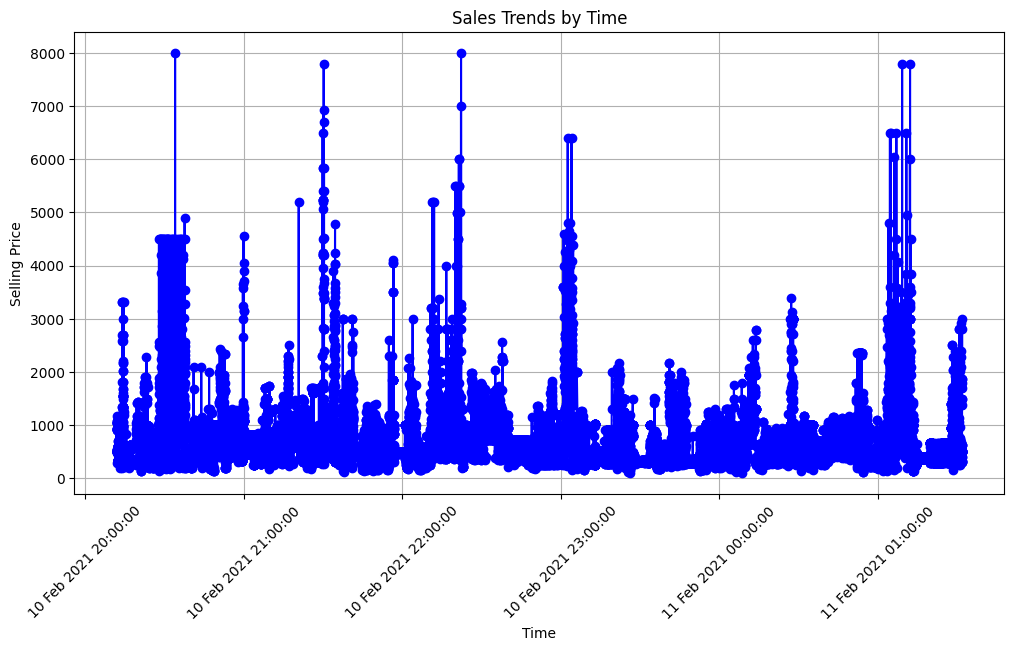

In [ ]:
# Convert 'crawled_at' column to datetime format
df['crawled_at'] = pd.to_datetime(df['crawled_at'], format='%m/%d/%Y, %H:%M:%S')

# Extract month from 'crawled_at' and create a new column 'month'
df['month'] = df['crawled_at'].dt.to_period('M')

df['crawled_at'] = pd.to_datetime(df['crawled_at'], format='%d/%m/%Y %H:%M:%S')
print(df['selling_price'].dtype)
df['selling_price'] = df['selling_price'].astype(str).str.replace(',', '')
df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce')
df['hour'] = df['crawled_at'].dt.hour
df['minute'] = df['crawled_at'].dt.minute
plt.figure(figsize=(12, 6))
plt.plot(df['crawled_at'], df['selling_price'], marker='o', linestyle='-', color='b')
plt.title('Sales Trends by Time')
plt.xlabel('Time')
plt.ylabel('Selling Price')
date_format = DateFormatter("%d %b %Y %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Calculate statistics
discounted_counts = len(df[df['discount'] != '0% off'])
non_discounted_counts = len(df[df['discount'] == '0% off'])
conversion_rate_discounted = len(df[(df['discount'] != '0% off') & (df['out_of_stock'] == False)]) / discounted_counts
conversion_rate_non_discounted = len(df[(df['discount'] == '0% off') & (df['out_of_stock'] == False)]) / non_discounted_counts
avg_order_value_discounted = df[df['discount'] != '0% off']['selling_price'].mean()
avg_order_value_non_discounted = df[df['discount'] == '0% off']['selling_price'].mean()

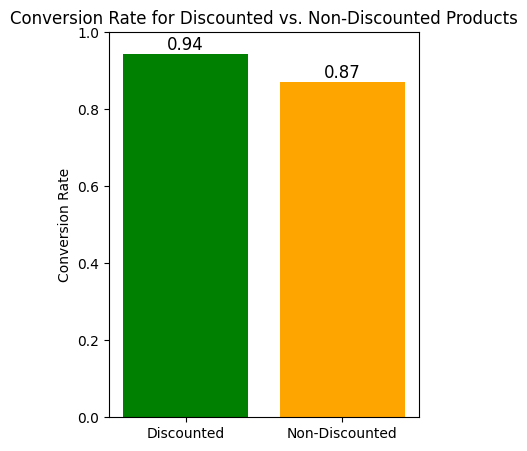

In [ ]:
# Conversion Rate Visualization with Legends
plt.figure(figsize=(4, 5))
bars = plt.bar(['Discounted', 'Non-Discounted'], [conversion_rate_discounted, conversion_rate_non_discounted], color=['green', 'orange'])
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate for Discounted vs. Non-Discounted Products')
plt.ylim(0, 1)

# Add Legends with Percentage Values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

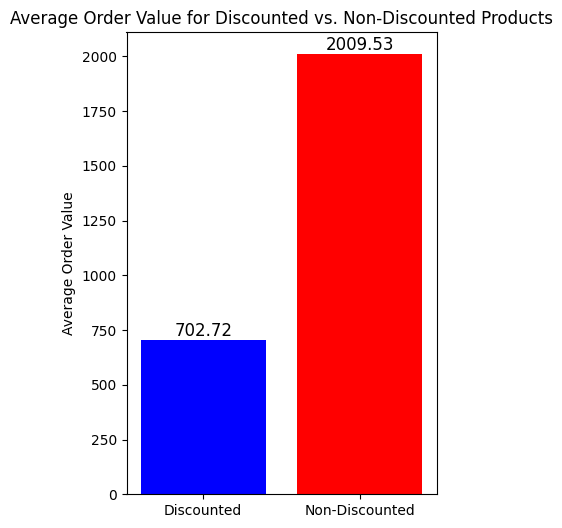

In [ ]:
# Average Order Value Visualization with Average Values Displayed on Bars
plt.figure(figsize=(4, 6))
bars = plt.bar(['Discounted', 'Non-Discounted'], [avg_order_value_discounted, avg_order_value_non_discounted], color=['blue', 'red'])
plt.ylabel('Average Order Value')
plt.title('Average Order Value for Discounted vs. Non-Discounted Products')

# Add Average Values on Top of Bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

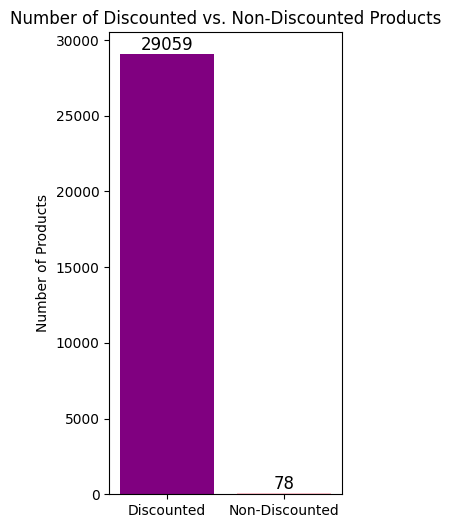

In [ ]:
# Number of Products Visualization with Numbers Displayed on Bars
plt.figure(figsize=(3, 6))
bars = plt.bar(['Discounted', 'Non-Discounted'], [discounted_counts, non_discounted_counts], color=['purple', 'pink'])
plt.ylabel('Number of Products')
plt.title('Number of Discounted vs. Non-Discounted Products')

# Add Numbers on Top of Bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', ha='center', va='bottom', fontsize=12)

plt.show()

In [ ]:
# Categorize discount levels
def categorize_discount(discount):
    if discount == '0% off':
        return 'No Discount'
    discount_value = int(discount.strip('% off'))
    if discount_value <= 10:
        return 'Low Discount'
    elif discount_value <= 30:
        return 'Medium Discount'
    else:
        return 'High Discount'

df['discount_level'] = df['discount'].apply(categorize_discount)

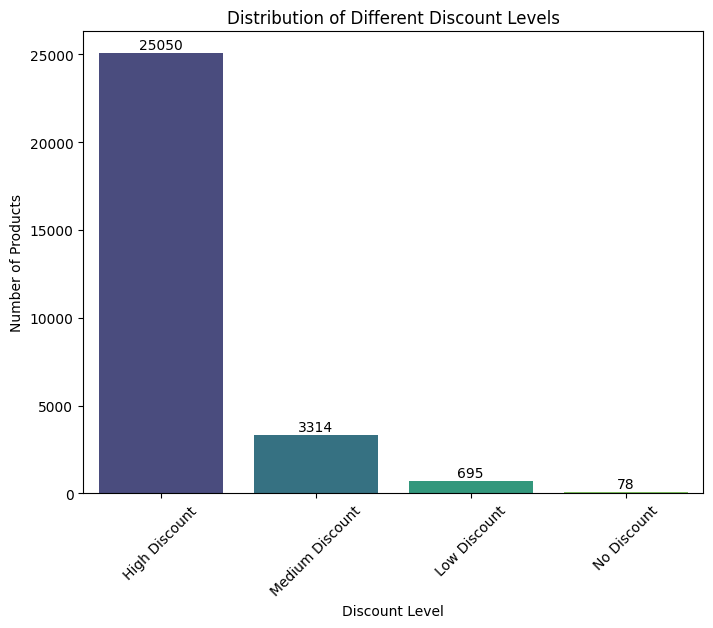

In [ ]:
# Count the occurrences of each discount level
discount_level_counts = df['discount_level'].value_counts()
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=discount_level_counts.index, y=discount_level_counts.values, palette="viridis")
# Add data labels (count) on top of the bars
for index, value in enumerate(discount_level_counts.values):
    plt.text(index, value + 50, str(value), ha='center', va='bottom')
# Add labels and title
plt.xlabel('Discount Level')
plt.ylabel('Number of Products')
plt.title('Distribution of Different Discount Levels')
# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [ ]:
df['actual_price'] = df['actual_price'].str.replace(',', '').astype(float)
df['discount'] = df['discount'].str.rstrip('% off').astype('float')

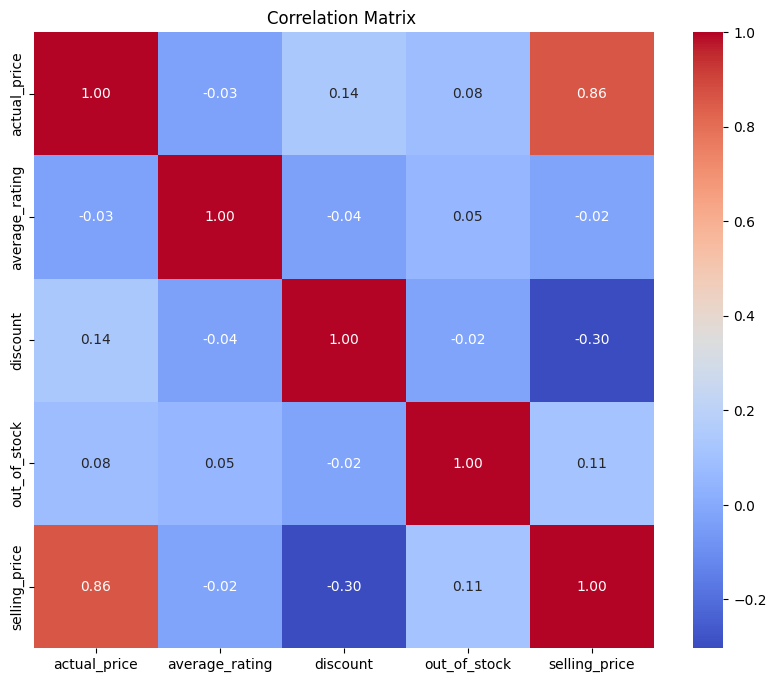

In [ ]:
correlation_matrix = df.drop(columns=['minute', 'hour']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix ')
plt.show()

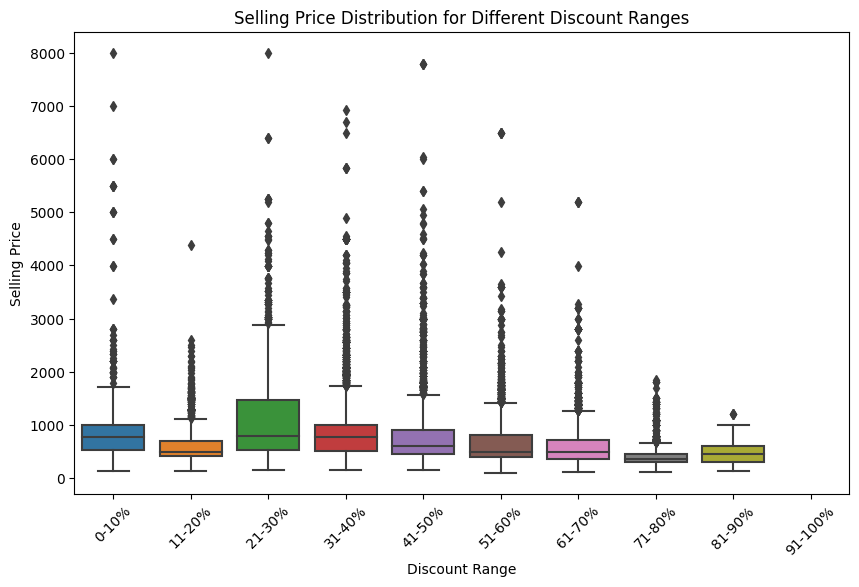

In [ ]:
# Define discount ranges
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '11-20%', '21-30%', '31-40%', '41-50%', '51-60%', '61-70%', '71-80%', '81-90%', '91-100%']

# Create a new column 'discount_range' by grouping 'discount' into predefined bins
df['discount_range'] = pd.cut(df['discount'], bins=bins, labels=labels, right=False)

# Create the box plot using the grouped discount ranges
plt.figure(figsize=(10, 6))
sns.boxplot(x='discount_range', y='selling_price', data=df)
plt.title('Selling Price Distribution for Different Discount Ranges')
plt.xlabel('Discount Range')
plt.ylabel('Selling Price')
plt.xticks(rotation=45)
plt.show()

<Axes: >

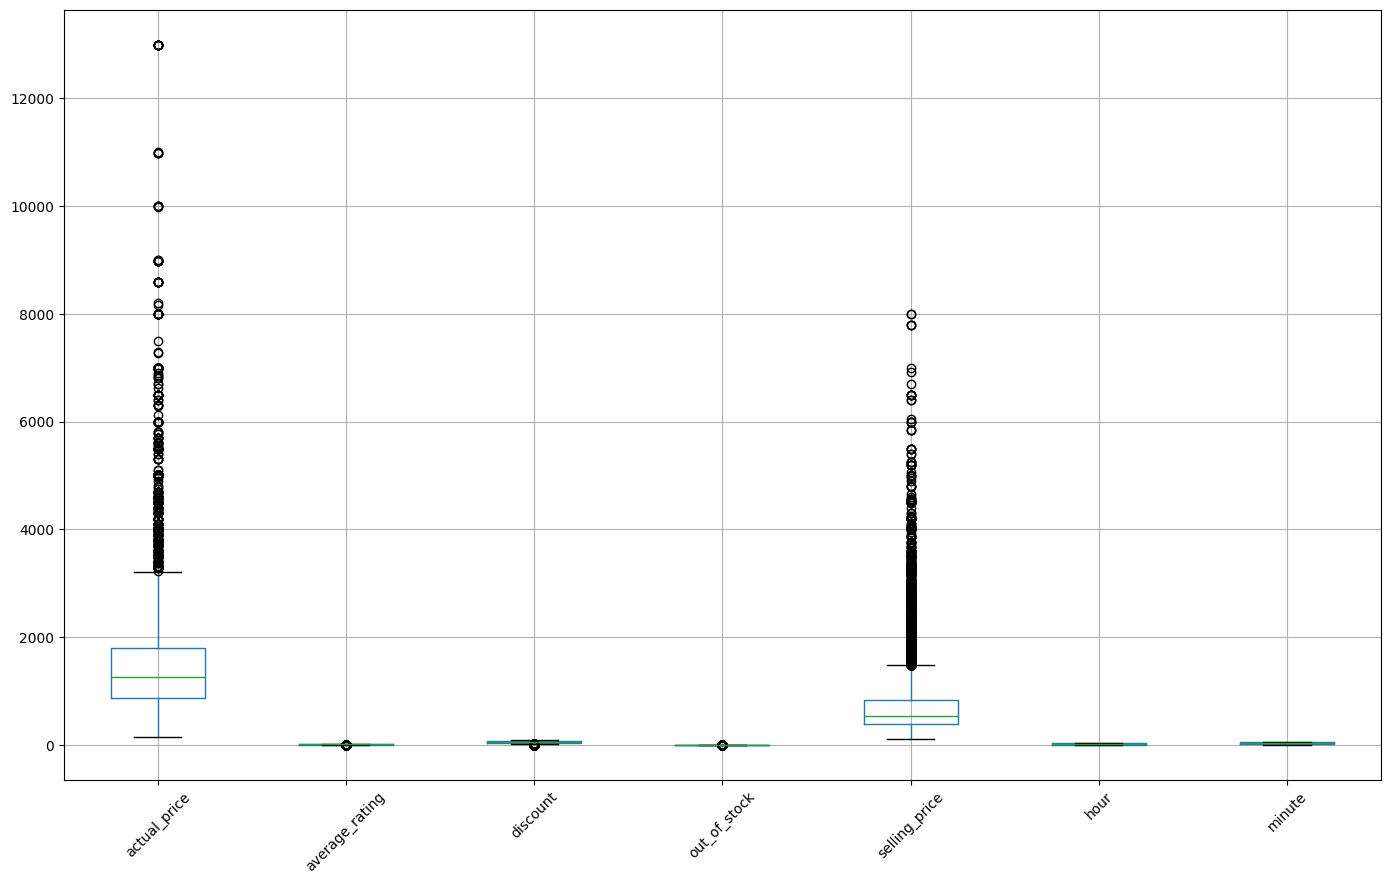

In [ ]:
df.boxplot(grid=True, rot=45, fontsize=10, figsize=(17,10))

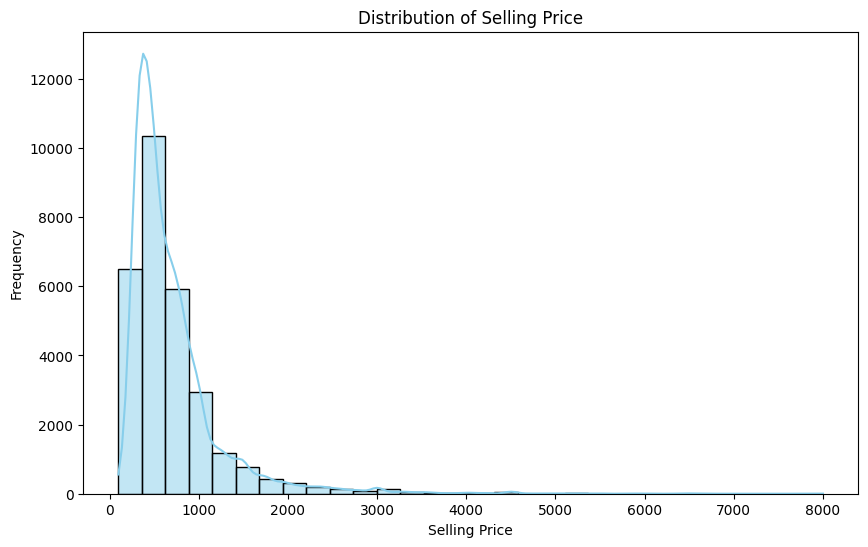

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of 'selling_price'
plt.figure(figsize=(10, 6))
sns.histplot(df['selling_price'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()


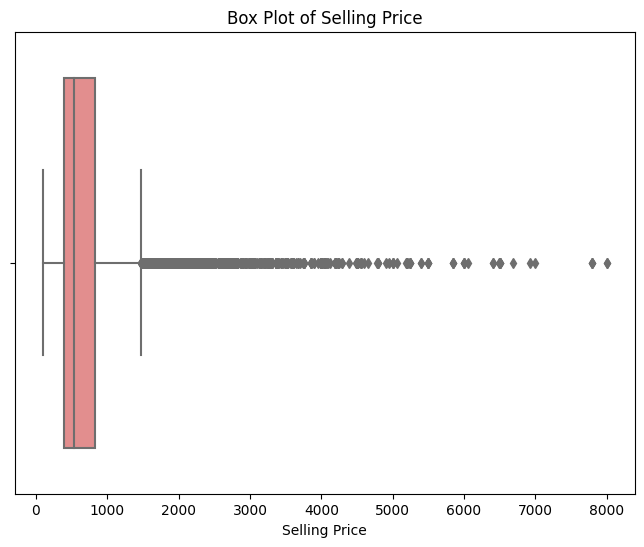

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['selling_price'], color='lightcoral')
plt.title('Box Plot of Selling Price')
plt.xlabel('Selling Price')
plt.show()


In [ ]:
from scipy.stats import zscore

# Calculate z-scores
z_scores = zscore(df['selling_price'])

# Define a threshold for outlier removal (e.g., z-score > 3 or < -3)
outlier_threshold = 3

# Identify and remove outliers
df_no_outliers = df[(z_scores > -outlier_threshold) & (z_scores < outlier_threshold)]

# Check the count of outliers
outliers_count = len(df) - len(df_no_outliers)
print(f'Number of outliers: {outliers_count}')


Number of outliers: 624


In [ ]:
# Calculate the IQR (Interquartile Range)
Q1 = df['selling_price'].quantile(0.25)
Q3 = df['selling_price'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier removal
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
df_no_outliers_iqr = df[(df['selling_price'] >= lower_bound) & (df['selling_price'] <= upper_bound)]

# Check the count of outliers after IQR method
outliers_count_iqr = len(df) - len(df_no_outliers_iqr)
print(f'Number of outliers after IQR method: {outliers_count_iqr}')


Number of outliers after IQR method: 2079


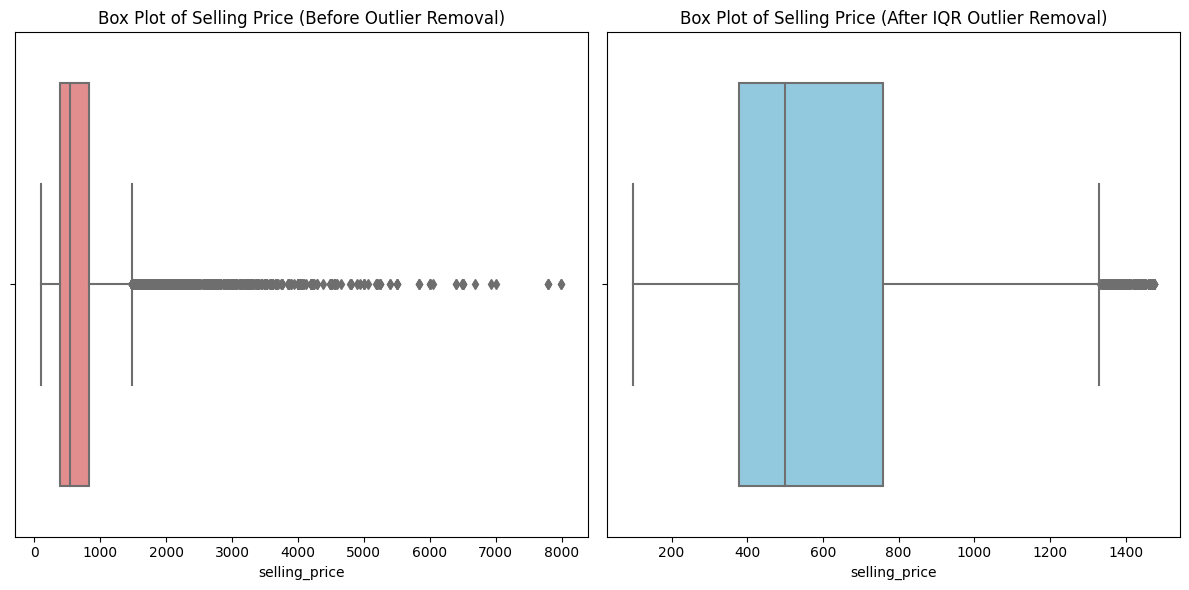

In [ ]:
plt.figure(figsize=(12, 6))

# Box plot before outlier removal
plt.subplot(1, 2, 1)
sns.boxplot(x=df['selling_price'], color='lightcoral')
plt.title('Box Plot of Selling Price (Before Outlier Removal)')

# Box plot after outlier removal using IQR
plt.subplot(1, 2, 2)
sns.boxplot(x=df_no_outliers_iqr['selling_price'], color='skyblue')
plt.title('Box Plot of Selling Price (After IQR Outlier Removal)')

plt.tight_layout()
plt.show()


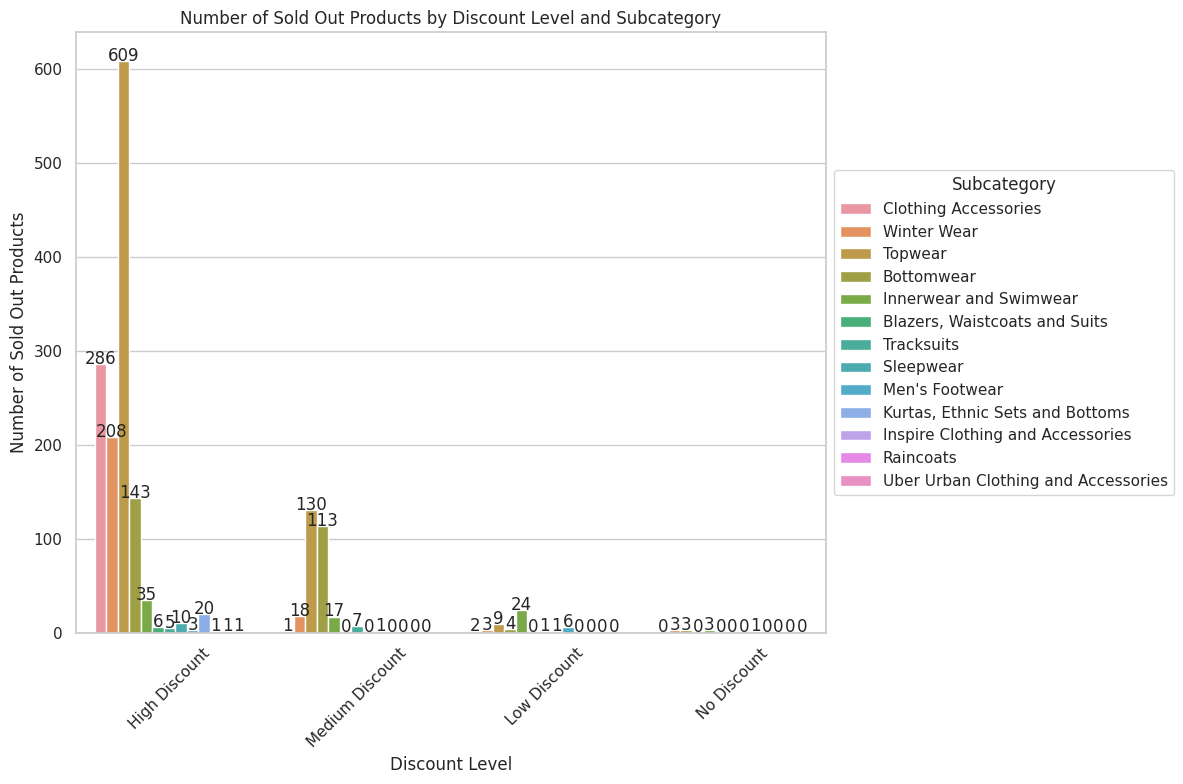

In [ ]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create a count plot for discount levels and subcategories with sold-out products
plt.figure(figsize=(12, 8))
sns.countplot(x='discount_level', hue='sub_category', data=df[df['out_of_stock'] == True])

# Display the count values on top of the bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{int(height)}', ha="center")

plt.xlabel('Discount Level')
plt.ylabel('Number of Sold Out Products')
plt.title('Number of Sold Out Products by Discount Level and Subcategory')
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Subcategory', title_fontsize='12', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
# ANOVA test
from scipy.stats import f_oneway
discount_ranges = df['discount_range'].unique()
groups = [df[df['discount_range'] == range]['selling_price'] for range in discount_ranges]

# Example: Creating a dictionary of discount ranges and corresponding selling prices
discount_range_groups = {}
for range in discount_ranges:
    selling_prices = df[df['discount_range'] == range]['selling_price']
    discount_range_groups[range] = list(selling_prices)

# Convert the dictionary to a DataFrame
discount_range_df = pd.DataFrame(discount_range_groups.items(), columns=['Discount Range', 'Selling Prices'])

# Display the new DataFrame
discount_range_df

f_stat, p_value = f_oneway(*groups)

print(f'F-statistic: {f_stat:.2f}')
print(f'P-value: {p_value:.4f}')

if p_value < 0.05:
    print("There is a significant difference in sales between different discount ranges.")
else:
    print("There is no significant difference in sales between different discount ranges.")

F-statistic: 497.72
P-value: 0.0000
There is a significant difference in sales between different discount ranges.


In [ ]:
# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
df['brand'] = label_encoder.fit_transform(df['brand'])
df['seller'] = label_encoder.fit_transform(df['seller'])
df['category'] = label_encoder.fit_transform(df['category'])
df['sub_category'] = label_encoder.fit_transform(df['sub_category'])
df['discount_level'] = label_encoder.fit_transform(df['discount_level'])

In [ ]:
df['discounted'] = df['discount'] != 0
df['discounted_percentage'] = df['discount']

In [ ]:
# Feature Selection
features = ['average_rating', 'brand', 'category', 'discount_level', 'out_of_stock', 'seller', 'sub_category', 'discounted', 'discounted_percentage']
X = df[features]
y = df['selling_price']

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2:.2f}')

R-squared Score: 0.81


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}


In [ ]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [ ]:
best_params = grid_search.best_params_
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2:.2f}')
print(f'Best Hyperparameters: {best_params}')

R-squared Score: 0.81
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define a parameter grid to search through
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_xg = grid_search.best_params_

# Train XGBoost model with the best hyperparameters
best_xg_reg = xgb.XGBRegressor(**best_params_xg)
best_xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_best_xg = best_xg_reg.predict(X_test)

r2_best_xg = r2_score(y_test, y_pred_best_xg)

print(f'Best Hyperparameters: {best_params_xg}')
print(f'R-squared Score (XGBoost): {r2_best_xg:.2f}')


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
R-squared Score (XGBoost): 0.82


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Define the XGBoost regressor with the best hyperparameters obtained from the grid search
best_xg_reg = xgb.XGBRegressor(**best_params_xg)

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_xg_reg, X, y, scoring='r2', cv=kf)

# Print the R-squared scores for each fold
print("Cross-Validation R-squared Scores:", cv_scores)

# Print the mean R-squared score across all folds
print("Mean R-squared Score:", np.mean(cv_scores))


Cross-Validation R-squared Scores: [0.82270537 0.83480335 0.81609033 0.82118743 0.81829616]
Mean R-squared Score: 0.8226165289226632


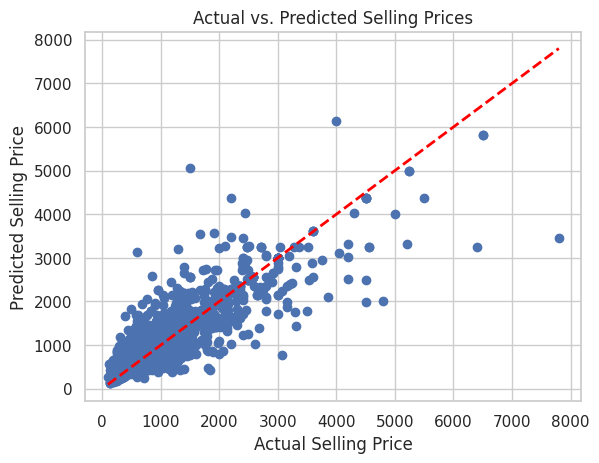

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)  # Diagonal line
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs. Predicted Selling Prices')
plt.show()

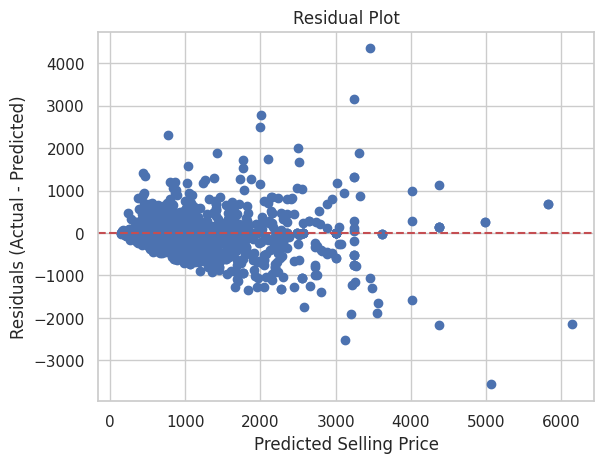

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Selling Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()